This notebook is a tutorial for computing SEACell metacells, visualizing results and computing evaluation metrics

# Imports

In [1]:
!pip install scanpy
!pip install SEACells

  Using cached networkx-3.2.1-py3-none-any.whl.metadata (5.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 1.9 MB/s eta 0:00:00
^C
ERROR: Operation cancelled by user
  Preparing metadata (setup.py) ... done
  Using cached numpy-1.26.4-cp310-cp310-macosx_10_9_x86_64.whl.metadata (61 kB)
  Using cached pandas-2.2.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (19 kB)
  Using cached scanpy-1.9.8-py3-none-any.whl.metadata (6.0 kB)
  Using cached anndata-0.10.5.post1-py3-none-any.whl.metadata (6.5 kB)
  Using cached numba-0.59.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (2.7 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.9 MB/s eta 0:00:00
  Using cached h5py-3.10.0-cp310-cp310-macosx_10_9_x86_64.whl.metadata (2.5 kB)
  Using cached joblib-1.3.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached matplotlib-3.8.3-cp310-cp310-macosx_10_12_x86_64.whl.metadata (5.8 kB)
  Using cached natsort-8.4.0-py3-none-any.whl.metadata (21 kB)
  Using cached networkx-3.2.1

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.spatial.distance import euclidean
import scipy as scp
import itertools as it
import math
import SEACells
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st
import umap as py

In [ ]:
# Some plotting aesthetics
%matplotlib inline

sns.set_style('ticks')
matplotlib.rcParams['figure.figsize'] = [4, 4]
matplotlib.rcParams['figure.dpi'] = 100


# Load Data

We recommend the use of scanpy Anndata objects as the preferred mode of loading and filtering data.

A sample datset is available for download with the instructions listed below. This is a filtered, unnormalized counts of single-nuclear RNA-seq dataset of CD34+ sorted bone marrow cells to profile human hematopoiesis [Dataset ref TBD].

Uncomment the following lines to download the sample dataset in a Unix-based system. For non-UNIX systems, download the files using the URL

In [ ]:
!mkdir data/
!wget https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad -O data/cd34_multiome_rna.h5ad 

--2023-05-04 00:30:20--  https://dp-lab-data-public.s3.amazonaws.com/SEACells-multiome/cd34_multiome_rna.h5ad
Resolving dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)... 54.231.236.41, 3.5.29.167, 52.216.134.67, ...
Connecting to dp-lab-data-public.s3.amazonaws.com (dp-lab-data-public.s3.amazonaws.com)|54.231.236.41|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152569842 (146M) [binary/octet-stream]
Saving to: ‘data/cd34_multiome_rna.h5ad’

data/cd34_multiome_ 100%[===================>] 145.50M  15.0MB/s    in 11s     

2023-05-04 00:30:33 (12.9 MB/s) - ‘data/cd34_multiome_rna.h5ad’ saved [152569842/152569842]



In [ ]:
# Load the data using 
ad = sc.read('data/cd34_multiome_rna.h5ad')

In [ ]:
ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype'
    var: 'highly_variable'
    uns: 'celltype_colors'
    obsm: 'X_umap'

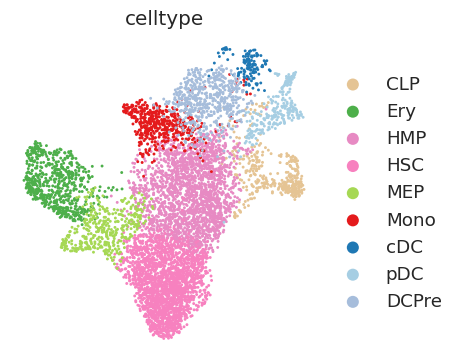

In [ ]:
# Plot cell-types for reference
sc.pl.scatter(ad, basis='umap', color='celltype', frameon=False)

# Pre-processing

The following section describes basic pre-processing steps for scRNA-seq. For scATAC-seq, we provide a pipeline for pre-processing in  in example notebook `preprocessing-ATAC.ipynb`

In [ ]:
# Copy the counts to ".raw" attribute of the anndata since it is necessary for downstream analysis
# This step should be performed after filtering 
raw_ad = sc.AnnData(ad.X)
raw_ad.obs_names, raw_ad.var_names = ad.obs_names, ad.var_names
ad.raw = raw_ad

In [ ]:
# Normalize cells, log transform and compute highly variable genes
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)
sc.pp.highly_variable_genes(ad, n_top_genes=1500)

In [ ]:
# Compute principal components - 
# Here we use 50 components. This number may also be selected by examining variance explaint
sc.tl.pca(ad, n_comps=50, use_highly_variable=True)

In [ ]:
#rna_ad in the other file
ad

AnnData object with n_obs × n_vars = 6881 × 12464
    obs: 'leiden', 'celltype', 'n_counts'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'celltype_colors', 'log1p', 'hvg', 'pca'
    obsm: 'X_umap', 'X_pca'
    varm: 'PCs'

# Running SEACells

As a rule of thumb, we recommended choosing one metacell for every 75 single-cells. Since this dataset contains ~7k cells, we choose 90 metacells.

<b>Note 1: </b> Running SEACells modifies the input Anndata object and adds the SEACell metacell assignments to the `obs` dataframe in the anndata object.
<b>Note 2: </b> This analysis takes approxmiately 5 minutes

In [ ]:
## User defined parameters

## Core parameters 
n_SEACells = 90
build_kernel_on = 'X_pca' # key in ad.obsm to use for computing metacells
                          # This would be replaced by 'X_svd' for ATAC data

## Additional parameters
n_waypoint_eigs = 10 # Number of eigenvalues to consider when initializing metacells

In [ ]:
model = SEACells.core.SEACells(ad, 
                  build_kernel_on=build_kernel_on, 
                  n_SEACells=n_SEACells, 
                  n_waypoint_eigs=n_waypoint_eigs,
                  convergence_epsilon = 1e-5)

Welcome to SEACells!


In [ ]:
model.construct_kernel_matrix()
M = model.kernel_matrix

Computing kNN graph using scanpy NN ...
Computing radius for adaptive bandwidth kernel...


  0%|          | 0/6881 [00:00<?, ?it/s]

Making graph symmetric...
Parameter graph_construction = union being used to build KNN graph...
Computing RBF kernel...


  0%|          | 0/6881 [00:00<?, ?it/s]

Building similarity LIL matrix...


  0%|          | 0/6881 [00:00<?, ?it/s]

Constructing CSR matrix...


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


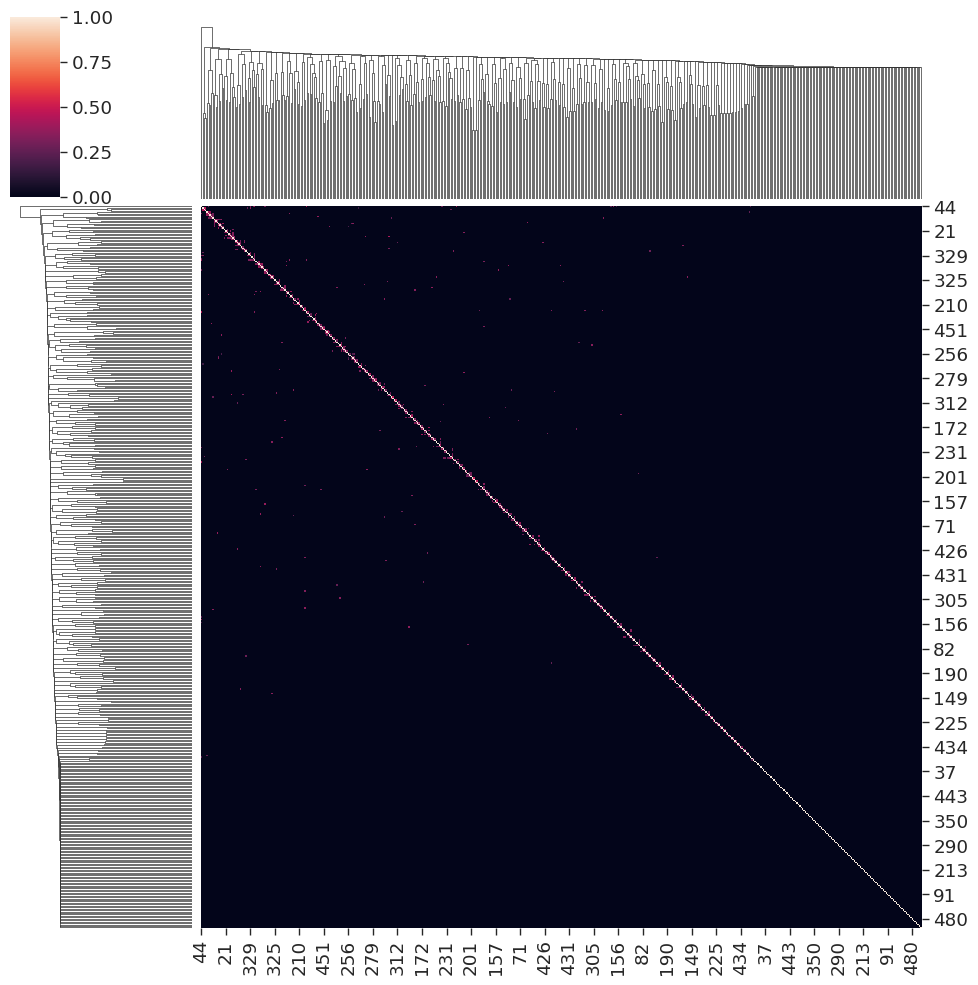

In [ ]:
sns.clustermap(M.toarray()[:500,:500])

In [ ]:
# Initialize archetypes
model.initialize_archetypes()

Building kernel on X_pca
Computing diffusion components from X_pca for waypoint initialization ... 
Determing nearest neighbor graph...
Done.
Sampling waypoints ...
Done.
Selecting 83 cells from waypoint initialization.
Initializing residual matrix using greedy column selection
Initializing f and g...


100%|██████████| 17/17 [00:00<00:00, 40.89it/s]

Selecting 7 cells from greedy initialization.


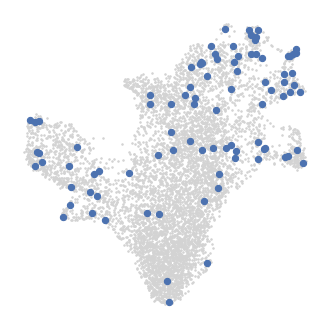

In [ ]:
# Plot the initilization to ensure they are spread across phenotypic space
SEACells.plot.plot_initialization(ad, model)

In [ ]:
model.fit(min_iter=10, max_iter=50)

Randomly initialized A matrix.
Setting convergence threshold at 0.00152
Starting iteration 1.
Completed iteration 1.
Starting iteration 10.
Completed iteration 10.
Starting iteration 20.
Completed iteration 20.
Converged after 29 iterations.


In [ ]:
# You can force the model to run additional iterations step-wise using the .step() function
print(f'Ran for {len(model.RSS_iters)} iterations')
for _ in range(5):
    model.step()
print(f'Ran for {len(model.RSS_iters)} iterations')

Ran for 30 iterations
Ran for 35 iterations


# Accessing results

## Model Convergence

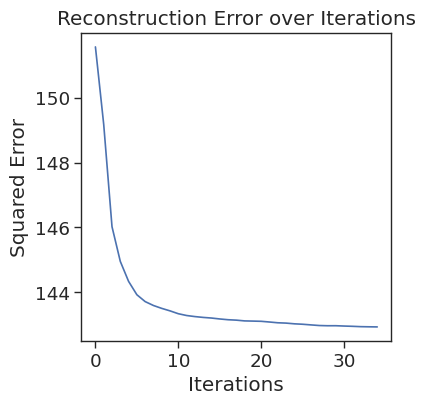

In [ ]:
# Check for convergence 
model.plot_convergence()

# Pickle Code

The following methods are used to download intermediate results for further processing. Equivalent to a sophisticated way of setting the seed in pseudo RNG.

In [ ]:
#Saving the model as a pickle oject

import pickle

your_data = model

# Store data (serialize)
with open('model_cd34_rna_81.pickle', 'wb') as handle:
    pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)



In [ ]:
#Downloading files from google.cola to local drive...this can also be done to drive.
from google.colab import files
files.download('intermediate_results_81.pickle')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#Loading the Model run with scRNA seq data and 90 metacells on 4/18 0010hrs
#Uploading the previously saved pickle file from local drive
from google.colab import files
files.upload()

In [ ]:
#Deserialising the imported pickle file

import pickle

# Load data (deserialize)
with open('model_cd34_rna.pickle', 'rb') as handle:
    model = pickle.load(handle)

# Edge Projection

* MB_graph(M matrix @ B matrix) -> complete graph representing the convex hull
* project_cells_MB(single cell coordinates, MB graph) -> project cells to the closest edge. Returns: the closest edge assignment, minimum distance to the closest edge, relative position on the closest edge (expressed in range(0,1)), list of distances to all edges of the MB graph.
* metacells_distance(MB graph) -> computes the distance between each two vertices of the convex hull (between each two metacells)








In [ ]:
def MB_graph(MB):

  graph = nx.Graph()

  for i in range(MB.shape[0]):
    SEACell_string = "SEACell-" + str(i)
    point = tuple(MB[i,:])
    graph.add_node((SEACell_string), pos=point)

  nodes = list(graph.nodes)
  for i in range(len(nodes)):
    for j in range(i+1, len(nodes)):
      graph.add_edge(nodes[i],nodes[j])

  return graph

In [ ]:
def project_cells_MB(cell, graph):

    min_distance = float('inf')
    closest_edge = None
    position = float('inf') 
    L = []  

    for edge in graph.edges:
        u, v = edge

        point1 = graph.nodes[u]['pos']
        point1 = np.array(point1)
  
        point2 = graph.nodes[v]['pos']
        point2 = np.array(point2)

        # Projecting to the edge
        v1 = cell - point1
        v2 = point2 - point1
        t = v1.dot(v2.T) / v2.dot(v2.T)
        
        # Enforcing the projection to the edge
        if 0 <= t <= 1:
            projection = point1 + t * v2
            distance = np.linalg.norm(projection - cell)
            L.append(distance)
            
            if distance < min_distance:
                min_distance = distance
                closest_edge = edge
                position = t

    position = position[0,0]

    return closest_edge, min_distance, position, np.array(L)

In [ ]:
def metacells_distance(graph):

    L = []
    
    for edge in graph.edges:
        u, v = edge

        point1 = graph.nodes[u]['pos']
        point1 = np.array(point1)
  
        point2 = graph.nodes[v]['pos']
        point2 = np.array(point2)

        L.append(np.linalg.norm(point1-point2))

    return L

In [ ]:
## Creating Matrix MB
A = model.A_.T
B = model.B_

MB = M @ B
MB = MB.T

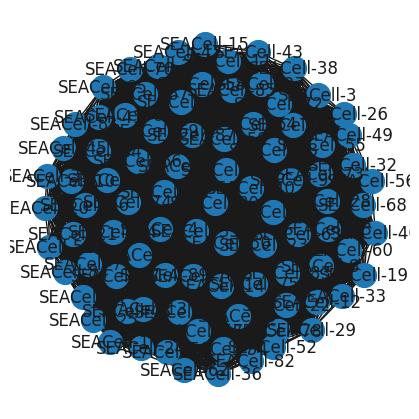

In [ ]:
# Building the Convex Hull (Complete Graph)

graph_MB = MB_graph(MB)
pos_MB = nx.spring_layout(graph_MB)
nx.draw(graph_MB, pos=pos_MB, with_labels=True)
plt.show()
plt.close()

# SEACell Hard Assignments

These can be accessed as folows:
- in the modified anndata object in `.obs['SEACell']` 
- from the model using `.get_hard_assignments()` 


In [ ]:
ad.obs[['SEACell']]

,SEACell
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,SEACell-4
cd34_multiome_rep1#AAACAGCCACTGACCG-1,SEACell-29
cd34_multiome_rep1#AAACAGCCATAATCAC-1,SEACell-49
cd34_multiome_rep1#AAACATGCAAATTCGT-1,SEACell-46
cd34_multiome_rep1#AAACATGCAGCATGTC-1,SEACell-30
...,...
cd34_multiome_rep2#TTTGTCTAGGGCCACT-1,SEACell-34
cd34_multiome_rep2#TTTGTGAAGGAAGCAC-1,SEACell-68
cd34_multiome_rep2#TTTGTGAAGTAACCAC-1,SEACell-68


In [ ]:
model.get_hard_assignments()

,SEACell
index,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,SEACell-4
cd34_multiome_rep1#AAACAGCCACTGACCG-1,SEACell-29
cd34_multiome_rep1#AAACAGCCATAATCAC-1,SEACell-49
cd34_multiome_rep1#AAACATGCAAATTCGT-1,SEACell-46
cd34_multiome_rep1#AAACATGCAGCATGTC-1,SEACell-30
...,...
cd34_multiome_rep2#TTTGTCTAGGGCCACT-1,SEACell-34
cd34_multiome_rep2#TTTGTGAAGGAAGCAC-1,SEACell-68
cd34_multiome_rep2#TTTGTGAAGTAACCAC-1,SEACell-68


# SEACell Soft Assignments

Archetypal analysis returns soft assignments of cells to SEACells. The full assignment matrix can be accessed as the parameter ```model.A_```. However, the majority of single-cells are assigned to no more than 4 archetypes with non-trivial weight, so we return the top 5 metacell assignments as well as the corresponding assignment weights in the function ```model.get_soft_assignments()```

<ipython-input-28-3262bc0ecac5>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)


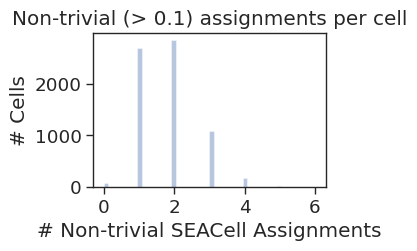

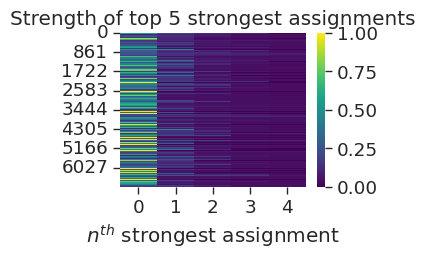

In [ ]:
plt.figure(figsize=(3,2))
sns.distplot((model.A_.T > 0.1).sum(axis=1), kde=False)
plt.title(f'Non-trivial (> 0.1) assignments per cell')
plt.xlabel('# Non-trivial SEACell Assignments')
plt.ylabel('# Cells')
plt.show()

plt.figure(figsize=(3,2))
b = np.partition(model.A_.T, -5)    
sns.heatmap(np.sort(b[:,-5:])[:, ::-1], cmap='viridis', vmin=0)
plt.title('Strength of top 5 strongest assignments')
plt.xlabel('$n^{th}$ strongest assignment')
plt.show()


In [ ]:
labels,weights = model.get_soft_assignments()

In [ ]:
labels.head()

,0,1,2,3,4
index,,,,,
cd34_multiome_rep1#AAACAGCCACTCGCTC-1,cd34_multiome_rep2#TAGTCAATCTGTGCAG-1,cd34_multiome_rep2#TCCAGCAAGGATTGCT-1,cd34_multiome_rep2#GTTAATGTCGTGCTAG-1,cd34_multiome_rep1#AAGTTTGTCGAAGTGA-1,cd34_multiome_rep1#TAGGAACCATTCAGCA-1
cd34_multiome_rep1#AAACAGCCACTGACCG-1,cd34_multiome_rep2#ACAACACTCATGCGTG-1,cd34_multiome_rep2#TACTTCGTCAAACCTA-1,cd34_multiome_rep1#ATTTGCGCAGGCTAGA-1,cd34_multiome_rep2#GTTACGCCAAGGTGGC-1,cd34_multiome_rep2#CAGGACCTCCCTCAAC-1
cd34_multiome_rep1#AAACAGCCATAATCAC-1,cd34_multiome_rep1#GCGTGCTAGTAACGAG-1,cd34_multiome_rep1#ATTAGTCCACCTGCCT-1,cd34_multiome_rep1#ACTTAGTCATTCCTCG-1,cd34_multiome_rep1#CCATAGCCATGGCCTG-1,cd34_multiome_rep1#GTCGCAATCACTTTAC-1
cd34_multiome_rep1#AAACATGCAAATTCGT-1,cd34_multiome_rep1#CCATAGCCATGGCCTG-1,cd34_multiome_rep2#GCTAACAGTGATGAAA-1,cd34_multiome_rep2#TAGGTTATCCGCAACA-1,cd34_multiome_rep1#ATTTGCGCAGGCTAGA-1,cd34_multiome_rep1#TATGGTCAGTGAACGA-1
cd34_multiome_rep1#AAACATGCAGCATGTC-1,cd34_multiome_rep1#TAGGAACCATTCAGCA-1,cd34_multiome_rep2#CCGATGCAGTAACCCG-1,cd34_multiome_rep2#CTCCCTGAGCCATCAG-1,cd34_multiome_rep1#ATGATGACAGCTCAAC-1,cd34_multiome_rep2#GACTAATGTGGATGTC-1


# Summarizing data

- `core.summarize_by_SEACell()`

Datasets can be summarized by SEACell by aggregating cells within each SEACell, summing over all raw data for all cells belonging to a SEACell. The output of this function is an anndata object of shape n_metacells x original_data_dimension. Data is unnormalized and raw aggregated counts are stored in `X`. Attributes associated with variables (.var) are copied over, but relevant per SEACell attributes must be manually copied, since certain attributes may need to be summed, or averaged etc, depending on the attribute.

By default, `ad.raw` is used for summarization. Other layers present in the anndata can be specified using the parameter `summarize_layer` parameter

In [ ]:
SEACell_ad = SEACells.core.summarize_by_SEACell(ad, SEACells_label='SEACell', summarize_layer='raw')
SEACell_ad

100%|██████████| 90/90 [00:00<00:00, 208.00it/s]


AnnData object with n_obs × n_vars = 90 × 12464
    layers: 'raw'

Alternatively, we can take into account soft assignments of cells to SEACells by weighting cells by the strength of the assignment. A minimum assignment weight is used to zero out trivial assignments

In [ ]:
SEACell_soft_ad = SEACells.core.summarize_by_soft_SEACell(ad, model.A_, celltype_label='celltype',summarize_layer='raw', minimum_weight=0.05)
SEACell_soft_ad

100%|██████████| 90/90 [02:01<00:00,  1.35s/it]


AnnData object with n_obs × n_vars = 90 × 12464
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

In [ ]:
SEACell_soft_ad

AnnData object with n_obs × n_vars = 90 × 12464
    obs: 'Pseudo-sizes', 'celltype', 'celltype_purity'

# Dictionaries

The following section builds dictionaries that are subsequently downloaded as Pickle objects for further, faster and more optimized, processing.

* metacell_dictionary(MB matrix) -> generates the metacells hash table with SEACell assignment as key and location as the value.
* edge_dictionary(graph of MB) -> generates the edge hash table with edge number as the key, tuple(length and 2 Metacells) as the value.
* cell_dictionary(hard SEACells Assignment , A matrix, M matrix, graph_MB, dictionary range start value, dictionary range end value) --> generates the hash table with cell number as the key, tuple(hard SEACells Assignment, closest edge, distance to all edges, relative position on the edge, weight) as the value.

In [ ]:
def metacell_dictionary(MB):

  metacell_dictionary = {}

  for i in range(MB.shape[0]):
    SEACell_string = "SEACell-" + str(i)
    point = tuple(MB[i,:])
    metacell_dictionary[SEACell_string] = point

  return metacell_dictionary 

In [ ]:
##### EXAMPLE #####
metacellsd = metacell_dictionary(MB)
print(metacellsd.get("SEACell-89"))

(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.055872520631737796, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1057591454565472, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [ ]:
def edge_dictionary(graph):

  edge_dictionary = {}
    
  for i, edge in enumerate(graph.edges):
    
    u, v = edge

    point1 = graph.nodes[u]['pos']
    point1 = np.array(point1)
  
    point2 = graph.nodes[v]['pos']
    point2 = np.array(point2)

    length = np.linalg.norm(point1 - point2)

    edge_dictionary[i] = (length, edge)

  return edge_dictionary

In [ ]:
##### EXAMPLE #####
edged = edge_dictionary(graph_MB)
print(edged.get(1))

(2.240292609049801, ('SEACell-0', 'SEACell-2'))


In [ ]:
def cell_dictionary(ad, A, M, graph_MB,x1,x2):

  cell_dictionary = {}

  for i in range(x1,x2):

    cellname=ad.obs.index[i]
    seacell_assignment = ad.obs[['SEACell']].iloc[i,0]
    projection_assignment, _, position, t_distances = project_cells_MB(M[i,:], graph_MB)
    weights=A[i,:]
    max_weight = max(A[i,:])

    cell_dictionary[cellname] = (seacell_assignment, projection_assignment, position, t_distances, weights, max_weight)

  return cell_dictionary

In [ ]:
##### EXAMPLE #####
celld = cell_dictionary(ad, A, M, graph_MB,0,1)
celld

{'cd34_multiome_rep1#AAACAGCCACTCGCTC-1': ('SEACell-4',
  ('SEACell-4', 'SEACell-73'),
  0.25119834384718925,
  array([2.27679647, 2.34808695, 2.2639669 , ..., 2.34571764, 2.35976783,
         2.32927275]),
  array([0.        , 0.        , 0.        , 0.        , 0.5772549 ,
         0.        , 0.        , 0.        , 0.00941176, 0.01490196,
         0.        , 0.        , 0.        , 0.02352941, 0.        ,
         0.        , 0.        , 0.02745098, 0.        , 0.        ,
         0.        , 0.02901961, 0.        , 0.        , 0.        ,
         0.        , 0.07137255, 0.        , 0.        , 0.        ,
         0.03843137, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00078431, 0.        , 0.        , 0.        , 0.05803922,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0

In [ ]:
#SAVING M, A, B, ad, metacell soft and hard assignements, SEACell_ad, SEACell_soft_ad

import pickle

your_data = (M,A,B,ad,labels,weights,SEACell_ad,SEACell_soft_ad)

# Store data (serialize)
with open('intermediate_results_81.pickle', 'wb') as handle:
    pickle.dump(your_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 3D Projections and Examples

* create_3combinations_matrix(MB matrix) -> simplifies the procedure of computing N choose 3 by producing a matrix whose 3 consecutive rows represent the output of N choose 3 function. Returns this matrix as well as a list which keeps track of original indices of each of the matrix rows.
* plane_graph(M matrix, original indices) -> builds a graph in which each vertex represents a plane of the N choose 3 SEACells metacells. Edges in this graph would represent the intersection between two given planes [NOT IMPLEMENTED].
* project_cell_to_graph(single cell coordinates, graph of planes) -> project the single cell to planes in the graph of planes. Returns the closest plane assignment, distances to all the planes in the graph, as well as the position on the closest plane.

In [ ]:
def create_3combinations_matrix(matrix):
  result = np.zeros((3*math.comb(matrix.shape[0],3), matrix.shape[1]))
  original_indices = []
  for i, j in enumerate(it.combinations(enumerate(matrix), 3)):
      (idx1, row1), (idx2, row2), (idx3, row3) = j
      original_indices.append(idx1)
      original_indices.append(idx2)
      original_indices.append(idx3)
      result[i*3+0] = row1
      result[i*3+1] = row2
      result[i*3+2] = row3
  return result, original_indices

In [ ]:
def plane_graph(M, original_indices):
    g3d = nx.Graph()
    
    for i in range(0,M.shape[0],3):
        row1 = M[i]
        row2 = M[i+1]
        row3 = M[i+2]
        
        fake_normal = (row2 - row1, row3 - row1)
        
        name1 = "SEACell-" + str(original_indices[i])
        name2 = "SEACell-" + str(original_indices[i+1])
        name3 = "SEACell-" + str(original_indices[i+2])
        node_id = (name1, name2, name3)
        g3d.add_node(node_id, normal=fake_normal)
    
    return g3d

In [ ]:
def project_cell_to_graph(cell_coord, g3d):
    distances = []
    closest_plane = None
    min_distance = np.inf
    position = None
        
    for node, data in g3d.nodes(data=True):
      v1, v2 = data['normal']

      u1 = v1 / np.linalg.norm(v1)
      u2 = v2 - np.dot(v2, u1) * u1
      u2 = u2 / np.linalg.norm(u2)

      W = lambda x: np.dot(x, u1) * u1 + np.dot(x, u2) * u2
      w = cell_coord - W(cell_coord)
      w = w.flatten()

      distance = np.linalg.norm(w)
      distances.append(distance)
      if distance < min_distance:
        closest_plane = node
        min_distance = distance
        position = w
    
    return closest_plane, distances, position

In [ ]:
## Creating a toy example illustrating projection methodology
MB_mini = np.zeros((10, 6881))
for i in range(10):
  MB_mini[i] = MB[i,:]

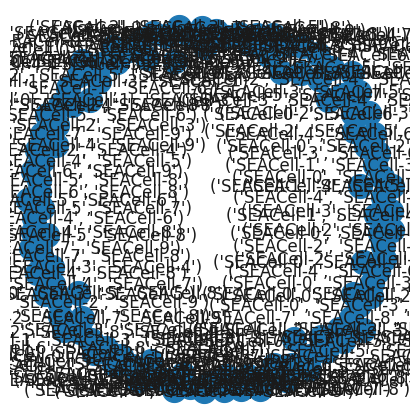

In [ ]:
### Example of computing the (3D) graph of planes.

mb_modified, new_indices = create_3combinations_matrix(MB_mini)
graph3d = plane_graph(mb_modified, new_indices)
pos_graph3d = nx.spring_layout(graph3d)
nx.draw(graph3d, pos=pos_graph3d, with_labels=True)
plt.show()
plt.close()

In [ ]:
### Example Continued.
### This prints out the closest plane to a given single cell of M matrix
### distances_in3d is the list with distance projections to all the planes

for i in range(10):
  cell_coord = M[i].toarray()
  plane, distances_in3d, position = project_cell_to_graph(cell_coord,graph3d)
  print(plane)
  print(st.mean(distances_in3d))
  print(st.mean(position))

('SEACell-3', 'SEACell-4', 'SEACell-8')
2.0398402753429004
0.0015685717515290314
('SEACell-0', 'SEACell-1', 'SEACell-2')
1.537898202416826
0.0007997552108355155
('SEACell-3', 'SEACell-5', 'SEACell-8')
1.7722040867514095
0.0010760680771422352
('SEACell-3', 'SEACell-4', 'SEACell-8')
1.8679544553629688
0.001172411997839222
('SEACell-0', 'SEACell-1', 'SEACell-2')
2.177057634263639
0.00175345753453217
('SEACell-1', 'SEACell-4', 'SEACell-5')
2.1216686536602447
0.0016330548076818941
('SEACell-4', 'SEACell-5', 'SEACell-8')
1.8061650198579293
0.0010958191380343043
('SEACell-0', 'SEACell-1', 'SEACell-2')
1.7131300685941544
0.0009747943547511687
('SEACell-3', 'SEACell-6', 'SEACell-8')
1.5949725097388257
0.0008410324253821824
('SEACell-3', 'SEACell-4', 'SEACell-8')
1.911931741731838
0.001247526911966295


# Evaluating Results

We provide several methods for evaluating SEACell assignments:

## Visualizing Results

Metacells also implements methods for visualizing the results of the Metacells algorithm 
    <ul> 
        <li>```.plot_2D()``` provides an interface for viewing metacell assignments on any 2-dimensional embedding in ad.obsm. Plots can also be coloured by metacell assignment.
        <li>```.plot_SEACell_sizes()``` can be used to view the distribution of number of cells assigned to each metacell
    </ul>
    
            

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


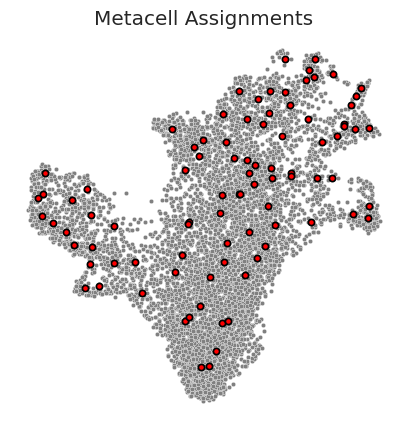

In [ ]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=False)

/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/usr/local/lib/python3.10/dist-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  points = ax.scatter(x=x, y=y, **kws)


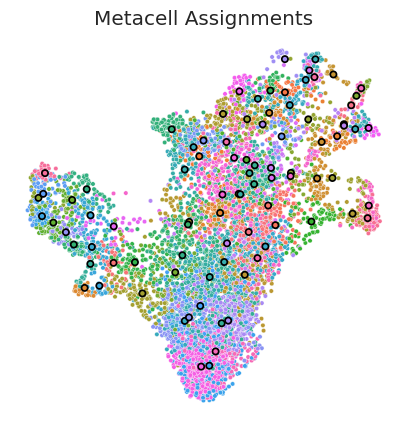

In [ ]:
SEACells.plot.plot_2D(ad, key='X_umap', colour_metacells=True)

/usr/local/lib/python3.10/dist-packages/SEACells/plot.py:121: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(label_df.groupby('SEACell').count().iloc[:, 0], bins=bins)


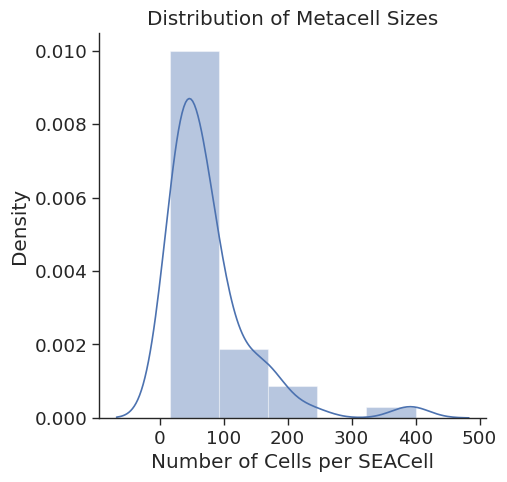

,size
SEACell,
SEACell-0,22
SEACell-1,126
SEACell-10,47
SEACell-11,73
SEACell-12,56
...,...
SEACell-86,101
SEACell-87,80
SEACell-88,21


In [ ]:
SEACells.plot.plot_SEACell_sizes(ad, bins=5)

## Quantifying Results

SEACells also implements methods for visualizing the results of the SEACells algorithm 
    <ul> 
        <li>```.compute_celltype_purity(ad, col_name)``` computes the purity of different celltype labels within a SEACell metacell. Typically, col_name='celltype' or similar. Returns a pd.DataFrame of length n_SEACells.
        <li>```.compactness(ad, low_dim_embedding)``` computes the per-SEAcell variance in diffusion components. ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. Lower values of compactness suggest more compact/lower variance metacells.
        <li>```separation(ad, low_dim_embedding,nth_nbr=1,cluster=None)``` computes the diffusion distance between a SEACell and its ```nth_nbr```. As before, ```low_dim_embedding``` is a string specifying the low dimensional embedding with which diffusion components are calculated, typically 'X_pca' for RNA or 'X_svd' for ATAC. If ```cluster``` is provided as a string, e.g. 'celltype', nearest neighbors are restricted to have the same celltype value.  Higher values of separation suggest better distinction between metacells.
    </ul>
    


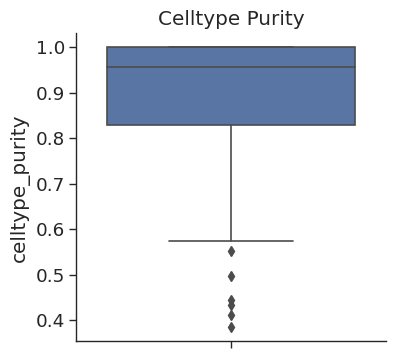

,celltype,celltype_purity
SEACell,,
SEACell-0,pDC,1.000000
SEACell-1,HMP,1.000000
SEACell-10,MEP,0.893617
SEACell-11,HMP,0.986301
SEACell-12,HMP,0.875000


In [ ]:
SEACell_purity = SEACells.evaluate.compute_celltype_purity(ad, 'celltype')

plt.figure(figsize=(4,4))
sns.boxplot(data=SEACell_purity, y='celltype_purity')
plt.title('Celltype Purity')
sns.despine()
plt.show()
plt.close()

SEACell_purity.head()

Determing nearest neighbor graph...


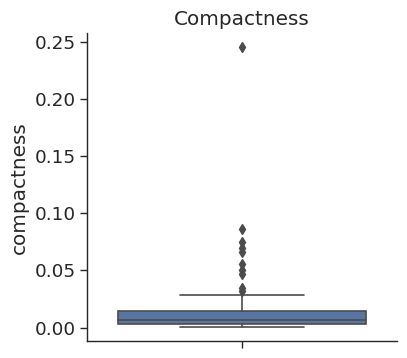

,compactness
SEACell,
SEACell-0,0.069575
SEACell-1,0.001587
SEACell-10,0.011667
SEACell-11,0.004097
SEACell-12,0.008786


In [ ]:
compactness = SEACells.evaluate.compactness(ad, 'X_pca')

plt.figure(figsize=(4,4))
sns.boxplot(data=compactness, y='compactness')
plt.title('Compactness')
sns.despine()
plt.show()
plt.close()

compactness.head()

Determing nearest neighbor graph...


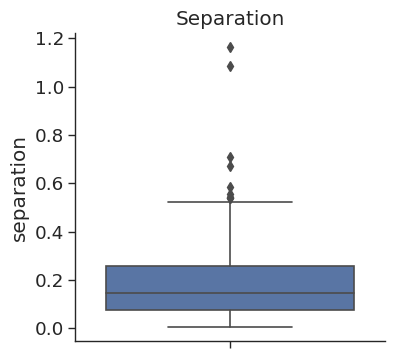

,separation
SEACell,
SEACell-0,0.707635
SEACell-1,0.068215
SEACell-10,0.522543
SEACell-11,0.161349
SEACell-12,0.202056


In [ ]:
separation = SEACells.evaluate.separation(ad, 'X_pca',nth_nbr=1)

plt.figure(figsize=(4,4))
sns.boxplot(data=separation, y='separation')
plt.title('Separation')
sns.despine()
plt.show()
plt.close()

separation.head()